In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


**1. Implement the box-counting algorithm for computing capacity dimension from an experimental data set. You are welcome to use any of the version that appear in the assigned reading. Please also give an english description of methods used.**

In [2]:
def count_boxes(trajectory, epsilon):
    """
    Count boxes in n-dimensional space
    """
    # First convert values to coordinates
    shifted_trajectory = np.array(trajectory / epsilon, dtype=int)
    sparse_array = {}
    for coord in shifted_trajectory:
        sparse_array[tuple(coord)] = 1
    return len(sparse_array.keys())

In [3]:
def box_counting(trajectory, epsilon_values):
    """
    Find capacity dimension
    """
    comp_func = lambda e: count_boxes(trajectory, e)
    return [comp_func(e) for e in epsilon_values]

In [4]:
def box_counting_parallel(trajectory_file, dimension, domain, numcores):
    open('outfile.csv', 'w')
    bins = np.array_split(domain, numcores)
    with open('bins.csv', 'w') as bf:
        writer = csv.writer(bf)
        for d in bins:
            writer.writerow(d)
    for i in range(numcores):
        command = 'python3 ./run_counts.py -b bins.csv -i {} -t {} -d {}&'\
                  .format(i, trajectory_file, dimension)
        os.system(command)

This algorithm takes advantage of the simple fact that we can convert the coordinates of the trajectory point into the coordinates for the hypercubes in our state space by dividing by the box width.

We start by dividing by the box width and truncating.

Then we simply need to figure out which boxes were entered. If we were to take a naive approach and create an $m^n$ sized state-space, we would need to mark each box as 1 and the figure out how many boxes were entered.

The issues with this approach are many. First and foremost is the fact that this has a huge memory requirement.

Instead we simply create a "sparse" matrix, where all entries are assumed to be zero by not initializing them, and all initialized coordinates are denoted by existing in the matrix. For each converted coordinate point in our trajectory, we add it to our sparse array and set the value to 1.

(More specifically, we take advantage of the fact the python dictionaries are very fast, and that tuples are hashable. This lets us convert the point into a tuple and use it as the key for our dictionary. Dictionaries won't allow duplicate keys, so our "sparse" matrix maintains its integrity.)

Finally, we simply count how many values have been entered in the array, which is allowed since each is set to 1.

This is the sneaky way to get around memory restrictions.

The parallel version on the other hand bins the domain into 8 different bins (how many cores my computer has) and runs each bin on a different core. This speeds it up significantly. I've attached the code from `run_counts.py` below in the appendix.

**2. (a) Test your algorithm on the embedded Lorenz attractor that you created for problem 6(a) on PS9. Explain your results and turn in a plot of $\log N(\epsilon)$ versus $\log(1 / \epsilon )$.**

We can run this on our data from problem set 9 with the embedded Lorenz Attractor. We first will create the embedded version with $\tau = 105$ and $m = 7$.

In [4]:
!delay -m 7 -d 105 ../problemset9/p6_lorenz.csv -o p6_lorenz_embedded.csv


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

delay: Produces delay vectors

Using ../problemset9/p6_lorenz.csv as datafile!
Using columns: 1 
get_multi_series: first data item(s) used:
28.000000 
Use 30001 lines.
Opened p6_lorenz_embedded.csv for writing


Now we specify the domain for the $\epsilon$ values.

In [5]:
domain = np.arange(100, 0, -0.01)

Now we can run it with the embedded values.

In [71]:
box_counting_parallel('./p6_lorenz_embedded.csv', 7, domain, 8)

Now we can plot our result and take the slope of the straight line. We know the general form of this line, so we don't need to plot both tails.

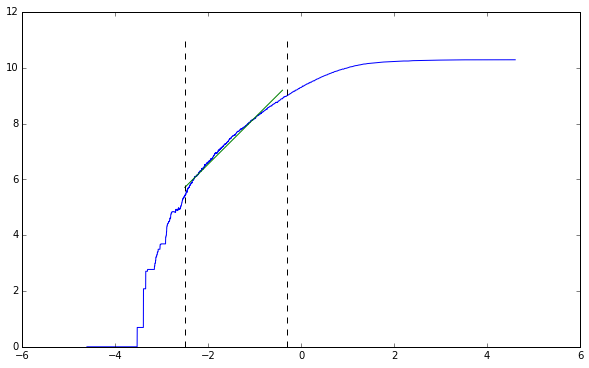

1.6596324049738598

In [21]:
vals = np.array(sorted(pd.read_csv('outfile1.csv', header=None).values,
                       key=lambda arr: arr[0]))[::-1]
points = np.transpose(np.array([np.log(1 / vals[:, 0]), np.log(vals[:, 1])]))

get_midpoints = lambda lower, upper, points: (
                    np.sort(
                        np.intersect1d(
                            np.where(lower <= points[:, 0]),
                            np.where(points[:, 0] <= upper)))

lower, upper = -2.5, -0.3

line_points = get_midpoints(lower, upper, points)
straight_section = points[line_points[0]:line_points[-1], :]

plt.figure(figsize=(10, 6))
plt.plot(points[:, 0], points[:, 1])
line_coeff = np.polyfit(straight_section[:, 0], straight_section[:, 1], 1)
line = lambda x: line_coeff[0] * x + line_coeff[1]
plt.plot(np.arange(lower, upper, 0.1), line(np.arange(lower, upper, 0.1)))
plt.plot(np.ones(12) * lower, np.arange(0, 12), 'k--')
plt.plot(np.ones(12) * upper, np.arange(0, 12), 'k--')
plt.show()

line_coeff[0]

We can clearly see that the straight period is maintained from $-2.5$ to $-0.3$. Fitting a line we see the slope is approximately equal to $1.65$.

**(b) Now try your box-counting algorithm on the original trajectory. Compare and contrast your results.**

In [86]:
box_counting_parallel('./p6_lorenz.csv', 3, domain, 8)

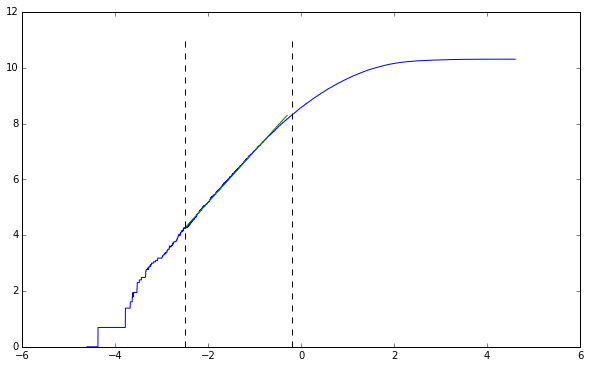

1.837431503147416

In [22]:
vals = np.array(sorted(pd.read_csv('outfile2.csv', header=None).values,
                       key=lambda arr: arr[0]))[::-1]
points = np.transpose(np.array([np.log(1 / vals[:, 0]), np.log(vals[:, 1])]))

lower, upper = -2.5, -0.2

line_points = get_midpoints(lower, upper, points)
straight_section = points[line_points[0]:line_points[-1], :]

plt.figure(figsize=(10, 6))
plt.plot(points[:, 0], points[:, 1])
line_coeff = np.polyfit(straight_section[:, 0], straight_section[:, 1], 1)
line = lambda x: line_coeff[0] * x + line_coeff[1]
plt.plot(np.arange(lower, upper, 0.1), line(np.arange(lower, upper, 0.1)))
plt.plot(np.ones(12) * lower, np.arange(0, 12), 'k--')
plt.plot(np.ones(12) * upper, np.arange(0, 12), 'k--')
plt.show()

line_coeff[0]

As we've talked about in class, the embedded trajectory has approximately the same capacity dimension as the original trajectory. We're off by a little bit, but more steps would fix this problem.

In terms of the algorithm, I've optimized the algorithm to the point that it would be harder to get better. Right now the parallelization is crude and clunky, using files as a means to transmit data. The next step would be to use python's `threading` module to do the parallelization.

**(c) Repeat part (b) of this problem with a longer version of the same trajectory. Do your results change? If so, which do you trust most? Why?**

Using prior code we can create a trajectory that is 100000 steps long instead of only 30000. We can then run our code on this trajectory.

In [6]:
box_counting_parallel('./p6_lorenz_100000.csv', 3, domain, 8)

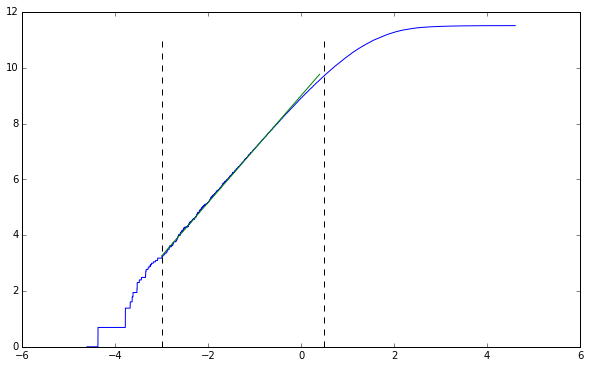

1.9168622269361926

In [23]:
vals = np.array(sorted(pd.read_csv('outfile3.csv', header=None).values,
                       key=lambda arr: arr[0]))[::-1]
points = np.transpose(np.array([np.log(1 / vals[:, 0]), np.log(vals[:, 1])]))

lower, upper = -3, 0.5

line_points = get_midpoints(lower, upper, points)
straight_section = points[line_points[0]:line_points[-1], :]

plt.figure(figsize=(10, 6))
plt.plot(points[:, 0], points[:, 1])
line_coeff = np.polyfit(straight_section[:, 0], straight_section[:, 1], 1)
line = lambda x: line_coeff[0] * x + line_coeff[1]
plt.plot(np.arange(lower, upper, 0.1), line(np.arange(lower, upper, 0.1)))
plt.plot(np.ones(12) * lower, np.arange(0, 12), 'k--')
plt.plot(np.ones(12) * upper, np.arange(0, 12), 'k--')
plt.show()

line_coeff[0]

Our results have changed from the previous attempts. It's much closer to $1.91$ now, and I trust this value much better. More results will mean the state-space has been more filled with the trajectory. By not filling this state-space (as was done with the initial two trajectories) we undercount how many hypercubes are crossed into because we don't have a full expression of the trajectory.

#Appendix

## run_counts.py

In [ ]:
#!/usr/bin/env python3

import numpy as np
import csv
import pandas as pd
import argparse
import sys

def main():
    args = get_args()
    bins = pd.read_csv(args.binfile, header=None)
    domain = np.array(bins.values[args.binnum], dtype=np.float64)
    trajectory = pd.read_csv(args.trajectory,
                    header=None, sep=' ').values[:, :args.dimension]
    values = box_counting(trajectory, domain)
    with open(args.outfile, 'a') as of:
        writer = csv.writer(of)
        for i in range(len(values)):
            writer.writerow([domain[i], values[i]])

def count_boxes(trajectory, epsilon):
    """
    Count boxes in n-dimensional space
    """
    # First convert values to coordinates
    shifted_trajectory = np.array(trajectory / epsilon, dtype=int)
    sparse_array = {}
    for coord in shifted_trajectory:
        sparse_array[tuple(coord)] = 1
    return len(sparse_array.keys())

def box_counting(trajectory, epsilon_values):
    """
    Find capacity dimension
    """
    comp_func = lambda e: count_boxes(trajectory, e)
    return [comp_func(e) for e in epsilon_values]

def get_args():
    parser = argparse.ArgumentParser(description='Run box-counting for a range')
    parser.add_argument('--binfile', '-b', type=str,
                        default='./bins.csv', help='Which binfile to use')
    parser.add_argument('--binnum', '-i', type=int,
                        default=0, help='Which bin line to use')
    parser.add_argument('--trajectory', '-t', type=str,
                        default='./trajectory.csv', help='Which trajectory to use')
    parser.add_argument('--outfile', '-o', type=str,
                        default='./outfile.csv', help='Which outfile to use')
    parser.add_argument('--dimension', '-d', type=int,
                        default=3, help='Dimension of the trajectory')
    args = parser.parse_args()
    return args

if __name__ == '__main__':
    sys.exit(main())

## Other Implementations

I also tried using Apache Spark. This method turned out to be worse. Spark is not intended for this.

In [ ]:
def spark_counting(domain, trajectory_file, dimension):
    shifted = sc.textFile(trajectory_file)\
                .map(lambda line: tuple([float(v) for v in line.split(',')][:dimension]))\
                .map(lambda tup: [tuple(int(v / e) for v in tup) for e in domain])\
                .reduce(lambda agg, nxt: [[agg[i]] + [nxt[i]] if type(agg[i]) is tuple else
                                          agg[i] + [nxt[i]] for i in range(len(domain))])
    vals = sc.parallelize(shifted)\
                .map(lambda row: row[:-1])\
                .map(lambda row: len(set(row)))\
                .collect()
    return vals

The optimized version creates an array for every $\epsilon$ value, and performs every operation at once. This implementation is much faster, although the principle remains the same. I don't use this optimized version, because as it turns out, it's not that much better than the non-optimized version, and if I optimize it further by using built-in `numpy` functions, I need more than 16GB of memory to contain the resulting float array.

In [7]:
def box_counting_optimized(trajectory, dimension, domain):
    bits = np.zeros((len(trajectory), len(domain), dimension), dtype=np.float64)

    for i in range(len(domain)):
        bits[:, i, :] = np.array(trajectory / domain[i], dtype=np.int)
    counts = [{} for i in domain]
    for i in range(len(trajectory)):
        for j in range(len(domain)):
            counts[j][tuple((int(k) for k in bits[i][j]))] = 1

    return [len(counts[i]) for i in range(len(domain))]